In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('preprocessed_water_quality.csv')

## Model Training

# Birch Clustering


Clustering Metrics:
Silhouette Score: 0.539
Calinski-Harabasz Index: 135410.552
Davies-Bouldin Index: 0.500

Number of clusters: 5

Cluster distribution:
0    7907
1    5216
2    7138
3    4960
4    3281
Name: count, dtype: int64


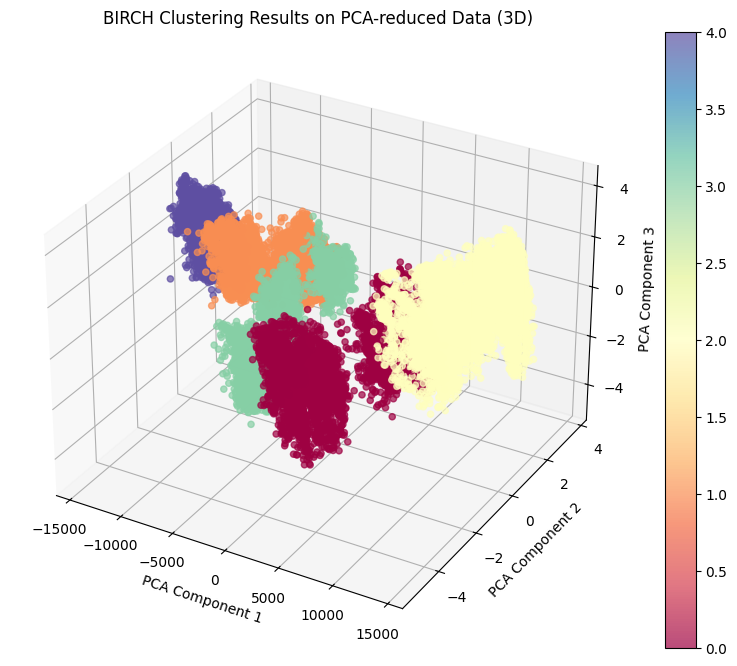


Cluster Characteristics:

Cluster 0:
Unnamed: 0    17410.000000
0                -1.335075
1                -0.716245
2                 0.548610
3                -0.154853
4                 0.029711
5                -0.251683
6                 0.371269
7                -0.230652
8                 0.053999
dtype: float64

Cluster 1:
Unnamed: 0    5888.500000
0                2.702535
1               -0.276996
2                0.221835
3                0.395145
4               -0.196387
5                0.116093
6               -0.112184
7               -0.130924
8               -0.429298
dtype: float64

Cluster 2:
Unnamed: 0    24932.500000
0                -1.139989
1                 0.812682
2                -1.465380
3                 0.094809
4                -0.075534
5                 0.215903
6                 0.045321
7                 0.185095
8                -0.086946
dtype: float64

Cluster 3:
Unnamed: 0    10976.500000
0                -0.492842
1                -0.570577


In [4]:
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd

# Apply PCA to reduce data to 3D for visualization
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# Create BIRCH clustering model
birch = Birch(n_clusters=5)  # Adjust clusters as needed

# Fit and predict clusters
clusters = birch.fit_predict(df)

# Add cluster labels to the DataFrame
df['Cluster'] = clusters

# Calculate clustering evaluation metrics
silhouette = silhouette_score(df, clusters)
calinski = calinski_harabasz_score(df, clusters)
davies = davies_bouldin_score(df, clusters)

print("\nClustering Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")
print(f"Davies-Bouldin Index: {davies:.3f}")

# Print basic clustering information
print(f"\nNumber of clusters: {len(set(clusters))}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of PCA-reduced data
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                      c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('BIRCH Clustering Results on PCA-reduced Data (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# Print cluster characteristics
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.mean().drop('Cluster'))

# Fuzzy C-Means


Clustering Metrics:
Silhouette Score: 0.560
Calinski-Harabasz Index: 170336.920
Davies-Bouldin Index: 0.500

Number of clusters: 5

Cluster distribution:
0    5845
1    5845
2    5458
3    5458
4    5896
Name: count, dtype: int64


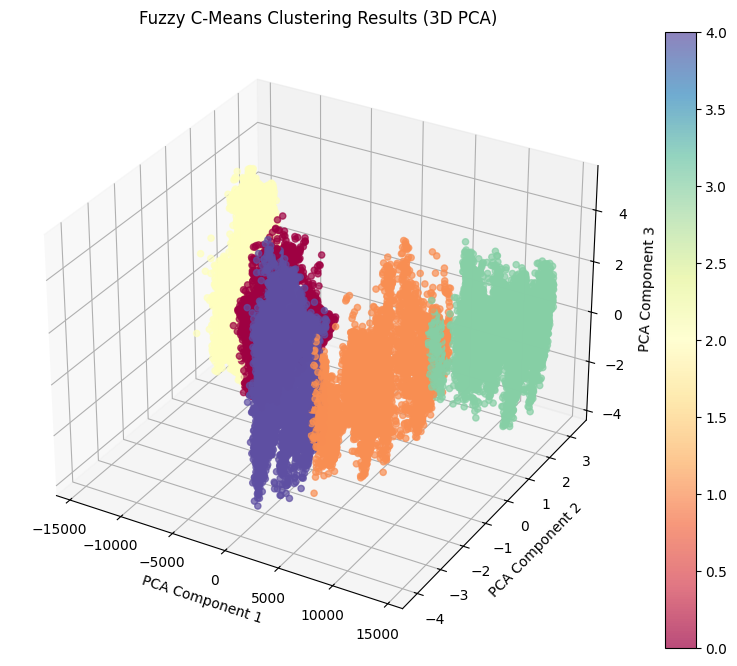


Cluster Characteristics:

Cluster 0:
Unnamed: 0    8380.000000
0                1.683480
1               -0.490743
2                0.535974
3                0.635521
4               -0.190721
5               -0.146057
6               -0.075334
7               -0.056412
8               -0.209632
dtype: float64

Cluster 1:
Unnamed: 0    20121.000000
0                -1.248492
1                -0.343908
2                -0.005031
3                 0.116606
4                -0.075633
5                -0.199590
6                 0.341104
7                -0.054562
8                 0.278012
dtype: float64

Cluster 2:
Unnamed: 0    2728.500000
0                2.164917
1                0.798181
2                0.045229
3               -0.550525
4                0.185014
5                0.207498
6               -0.360312
7                0.091994
8                0.147222
dtype: float64

Cluster 3:
Unnamed: 0    25772.500000
0                -0.998236
1                 1.124036
2         

In [5]:
from fcmeans import FCM
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- PCA Dimensionality Reduction to 3 Components ---
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# --- Fuzzy C-Means Clustering ---
n_clusters = 5
fcm = FCM(n_clusters=n_clusters, random_state=42)
fcm.fit(df.values)

# Predict cluster labels
clusters = fcm.predict(df.values)
df['Cluster'] = clusters

# --- Evaluation Metrics (Optional: Fuzzy labels can cause small inconsistency) ---
if len(np.unique(clusters)) > 1:
    silhouette = silhouette_score(df.drop('Cluster', axis=1), clusters)
    calinski = calinski_harabasz_score(df.drop('Cluster', axis=1), clusters)
    davies = davies_bouldin_score(df.drop('Cluster', axis=1), clusters)
    print("\nClustering Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Cluster Info ---
print(f"\nNumber of clusters: {n_clusters}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('Fuzzy C-Means Clustering Results (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# --- Cluster Characteristics ---
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.mean().drop('Cluster'))

# GMM

Python(5156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Clustering Metrics:
Silhouette Score: 0.560
Calinski-Harabasz Index: 170336.920
Davies-Bouldin Index: 0.500

Number of clusters: 5

Cluster distribution:
0    5896
1    5458
2    5458
3    5845
4    5845
Name: count, dtype: int64


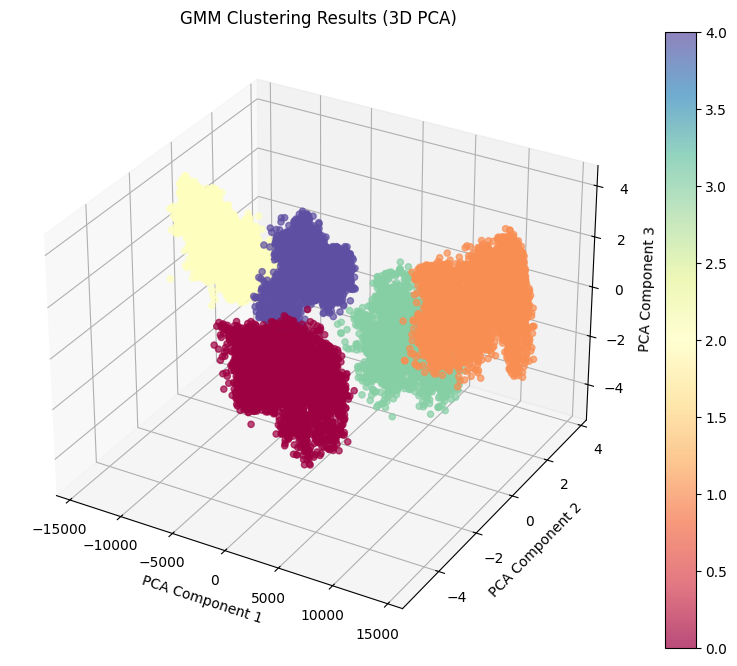


Cluster Characteristics:

Cluster 0:
Unnamed: 0    14250.500000
0                -1.511236
1                -0.951989
2                 1.195544
3                -0.303811
4                 0.152800
5                -0.011821
6                -0.049967
7                -0.032132
8                -0.074739
dtype: float64

Cluster 1:
Unnamed: 0    25772.500000
0                -0.998236
1                 1.124036
2                -1.905304
3                 0.073260
4                -0.064836
5                 0.175427
6                 0.129675
7                 0.061559
8                -0.139714
dtype: float64

Cluster 2:
Unnamed: 0    2728.500000
0                2.164917
1                0.798181
2                0.045229
3               -0.550525
4                0.185014
5                0.207498
6               -0.360312
7                0.091994
8                0.147222
dtype: float64

Cluster 3:
Unnamed: 0    20121.000000
0                -1.248492
1                -0.343908


In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- PCA Dimensionality Reduction to 3 Components ---
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# --- GMM Clustering ---
n_clusters = 5
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(df.values)

# Predict cluster labels
clusters = gmm.predict(df.values)
df['Cluster'] = clusters

# --- Evaluation Metrics ---
if len(np.unique(clusters)) > 1:
    silhouette = silhouette_score(df.drop('Cluster', axis=1), clusters)
    calinski = calinski_harabasz_score(df.drop('Cluster', axis=1), clusters)
    davies = davies_bouldin_score(df.drop('Cluster', axis=1), clusters)
    print("\nClustering Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Cluster Info ---
print(f"\nNumber of clusters: {n_clusters}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('GMM Clustering Results (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# --- Cluster Characteristics ---
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.mean().drop('Cluster'))

# OPTICS

In [7]:
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- PCA Dimensionality Reduction to 3 Components ---
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# --- OPTICS Clustering ---
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.1)  # You can tune parameters
clusters = optics.fit_predict(df)

# --- Add cluster labels ---
df['Cluster'] = clusters

# --- Calculate Clustering Metrics (excluding noise points) ---
mask = clusters != -1
if len(np.unique(clusters[mask])) > 1:
    silhouette = silhouette_score(df.drop('Cluster', axis=1)[mask], clusters[mask])
    calinski = calinski_harabasz_score(df.drop('Cluster', axis=1)[mask], clusters[mask])
    davies = davies_bouldin_score(df.drop('Cluster', axis=1)[mask], clusters[mask])
    print("\nClustering Metrics (excluding noise points):")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Basic Cluster Information ---
print(f"\nNumber of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of noise points: {list(clusters).count(-1)}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('OPTICS Clustering Results (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# --- Cluster Characteristics ---
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    if cluster != -1:
        cluster_data = df[df['Cluster'] == cluster]
        print(f"\nCluster {cluster}:")
        print(cluster_data.mean().drop('Cluster'))

# Spectral Clustering


Clustering Metrics:
Silhouette Score: 0.267
Calinski-Harabasz Index: 6618.092
Davies-Bouldin Index: 1.374

Number of clusters: 5

Cluster distribution:
0     6419
1    13585
2     5251
3     1521
4     1726
Name: count, dtype: int64


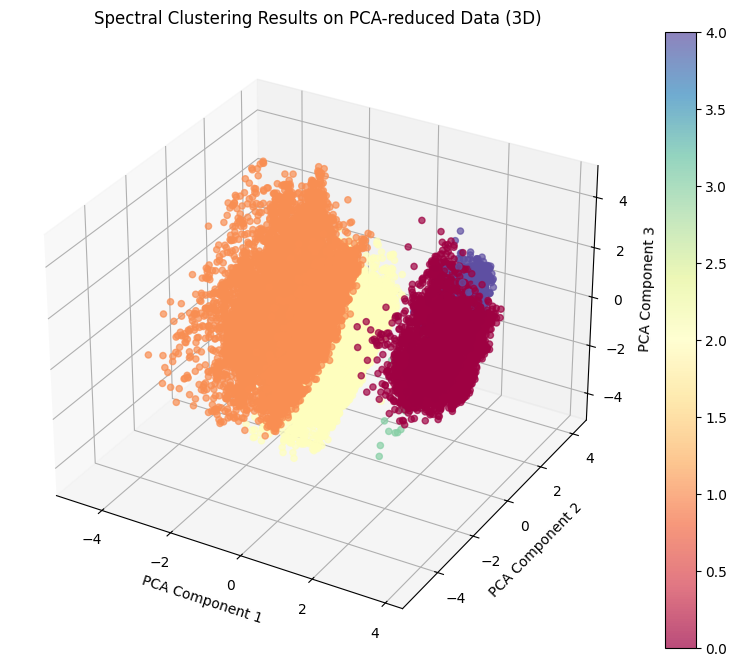


Cluster Characteristics:

Cluster 0:
0    2.699589
1   -0.377524
2    0.214743
3    0.491465
4   -0.229398
5    0.077380
6   -0.078627
7   -0.093808
8   -0.485480
dtype: float64

Cluster 1:
0   -1.398534
1   -0.592494
2    0.655260
3   -0.046015
4    0.043821
5   -0.108311
6    0.069193
7   -0.031971
8    0.165940
dtype: float64

Cluster 2:
0   -1.006948
1    1.176593
2   -1.987459
3    0.080612
4   -0.066374
5    0.162919
6    0.156634
7    0.042160
8   -0.171033
dtype: float64

Cluster 3:
0    2.172008
1    0.456504
2   -0.723979
3   -1.180840
4    0.573247
5   -0.172209
6   -0.758462
7    0.331108
8    0.562977
dtype: float64

Cluster 4:
0    2.117196
1    2.085589
2    0.728380
3   -0.670237
4    0.204996
5    0.220825
6   -0.060341
7    0.180467
8    0.523643
dtype: float64


In [63]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert all column names to strings (if necessary)
df.columns = df.columns.astype(str)

# Apply PCA to reduce data to 3D for visualization
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# Create Spectral Clustering model
n_clusters = 5  # You can adjust this
spectral = SpectralClustering(n_clusters=n_clusters,
                             affinity='nearest_neighbors',
                             random_state=42)

# Fit and predict clusters
clusters = spectral.fit_predict(df)

# Add cluster labels to the dataframe
df['Cluster'] = clusters

# Calculate clustering evaluation metrics
silhouette = silhouette_score(df, clusters)
calinski = calinski_harabasz_score(df, clusters)
davies = davies_bouldin_score(df, clusters)

print("\nClustering Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")
print(f"Davies-Bouldin Index: {davies:.3f}")

# Print basic clustering information
print(f"\nNumber of clusters: {n_clusters}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of PCA-reduced data
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                      c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('Spectral Clustering Results on PCA-reduced Data (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# Print cluster characteristics
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.mean().drop('Cluster'))

In [65]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import Birch
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# from sklearn.utils import resample

# # Number of bootstrap iterations
# n_bootstraps = 10  

# # Number of clusters for BIRCH
# n_clusters = 5  

# # Store clustering metrics across bootstraps
# silhouette_scores = []
# calinski_scores = []
# davies_scores = []
# cluster_results = []

# for i in range(n_bootstraps):
#     print(f"Bootstrap Iteration {i+1}/{n_bootstraps}...")

#     # Bootstrap resampling
#     df_sample = resample(df, replace=True, n_samples=len(df))

#     # Create and fit BIRCH model
#     birch = Birch(n_clusters=n_clusters)
#     clusters = birch.fit_predict(df_sample)

#     # Store cluster results
#     cluster_results.append(clusters)

#     # Compute clustering metrics
#     silhouette = silhouette_score(df_sample, clusters)
#     calinski = calinski_harabasz_score(df_sample, clusters)
#     davies = davies_bouldin_score(df_sample, clusters)

#     silhouette_scores.append(silhouette)
#     calinski_scores.append(calinski)
#     davies_scores.append(davies)

# # Compute mean and std for clustering metrics
# print("\nBootstrap Aggregated Metrics:")
# print(f"Silhouette Score: {np.mean(silhouette_scores):.3f} ± {np.std(silhouette_scores):.3f}")
# print(f"Calinski-Harabasz Index: {np.mean(calinski_scores):.3f} ± {np.std(calinski_scores):.3f}")
# print(f"Davies-Bouldin Index: {np.mean(davies_scores):.3f} ± {np.std(davies_scores):.3f}")

# # Visualize clusters from the last bootstrap iteration (for interpretation)
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=cluster_results[-1], cmap='Spectral', alpha=0.6)
# plt.colorbar(scatter)
# plt.title('BIRCH Clustering Results (Last Bootstrap Sample)')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()